# Initializing

In [21]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        %matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import unicodedata
from nltk.corpus import stopwords
import pickle
import mpld3

In [22]:
news_data = pd.read_csv("../data/Imigration_news_data_content.csv")
total_length = len(news_data)
content_list = news_data["content"].tolist()
date = news_data["date"].tolist()
ID = news_data["id"].tolist()
print total_length

32035


Load previous clean news data from local

In [23]:
start_year = 1990
end_year = 2005
year_range = range(start_year, end_year+1)
tmp_content_list = []
tmp_date_list = []
tmp_id_list = []
count = 0
for d in date:
    year = int(d[:4])
    if  year in year_range:
        tmp_date_list.append(date[count])
        tmp_content_list.append(content_list[count])
        tmp_id_list.append(ID[count])
    count += 1


The whole data set ranges from 1850 -2005 but we only focus on 1990-2005 here.

In [24]:
print len(tmp_content_list)
print len(tmp_date_list)


15727
15727


There are around 15727 articles here

In [25]:
content_list = tmp_content_list
date = tmp_date_list
ID = tmp_id_list

## Clean Words Content

In [26]:
def clean_words( raw_review , flag = False):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if (not w in stops and len(w) > 2)]   
    
    tmp_words = []
    for word in meaningful_words:
        tmp_words.append(unicodedata.normalize('NFKD', word).encode('ascii','ignore'))
    meaningful_words = tmp_words
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    if flag:
        return(meaningful_words )   
    return( " ".join( meaningful_words )) 

In [1]:
new_content_list = []
for content in content_list:
    new_content_list.append(clean_words(content))
content_list = new_content_list
print (len(content_list))
# print content_list[0]

In [8]:
total_length = len(content_list)

# Group Data

In [18]:
bin_num = 100

count = 0
bin_count = 0
general_bin_size = int(total_length/bin_num)
left_over = total_length - general_bin_size * bin_num
print "bin number is: " + str(bin_num)
print "gener bin size: ", general_bin_size
print "last bin size: ", general_bin_size + left_over

for i in range(bin_num):
    if i == (bin_num - 1):
        bin_size = general_bin_size + left_over
    else:
        bin_size = general_bin_size
        
    content = ""
    dates = ""
#     print "bin_size ", bin_size 
    for j in range(bin_size):
#         print count
        content += (content_list[count] + " ") 
        if j == 0:
            dates += (date[count] + ",")
        if j == (bin_size - 1):
            dates += (date[count])
        count += 1
    tmp_list = [{"date": dates, "content": content}]
    subset = pd.DataFrame(tmp_list)

    print "finsih adding bin number: ", bin_count
    if bin_count == 0:
        with open('Immigration_news_data_content_bin' + str(bin_num) + '.csv', 'a') as f:
            subset.to_csv(f, header = ['content', 'date'])
    else:
        with open('Immigration_news_data_content_bin' + str(bin_num) + '.csv', 'a') as f:
            subset.to_csv(f, header = False)
    bin_count += 1
    


bin number is: 100
gener bin size:  157
last bin size:  184
finsih adding bin number:  0
finsih adding bin number:  1
finsih adding bin number:  2
finsih adding bin number:  3
finsih adding bin number:  4
finsih adding bin number:  5
finsih adding bin number:  6
finsih adding bin number:  7
finsih adding bin number:  8
finsih adding bin number:  9
finsih adding bin number:  10
finsih adding bin number:  11
finsih adding bin number:  12
finsih adding bin number:  13
finsih adding bin number:  14
finsih adding bin number:  15
finsih adding bin number:  16
finsih adding bin number:  17
finsih adding bin number:  18
finsih adding bin number:  19
finsih adding bin number:  20
finsih adding bin number:  21
finsih adding bin number:  22
finsih adding bin number:  23
finsih adding bin number:  24
finsih adding bin number:  25
finsih adding bin number:  26
finsih adding bin number:  27
finsih adding bin number:  28
finsih adding bin number:  29
finsih adding bin number:  30
finsih adding bin nu

Sometimes if the there are too many news paper articles in the time range, then it will be a mess to cluster. So this script allows us to arbitrary choose the group number to group the articles into bins

In [28]:
bin_num = 100
news_data = pd.read_csv('Immigration_news_data_content_bin' + str(bin_num) + '.csv')
total_length = len(news_data)
content_list = news_data["content"].tolist()
date = news_data["date"].tolist()
# keywords = news_data['keywords'].tolist()
print (len(content_list))
print (len(date))


100
100


In [29]:
new_date = []
for i in range(len(date)):
    new_date.append(int(date[i][:4]))
date = new_date
print (len(date))


100


In [30]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(content_list)):
    ranks.append(i)
print len(ranks)

100


# Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [31]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')


Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [32]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [33]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [34]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in content_list:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    



In [36]:
print (len(totalvocab_stemmed))
print (len(totalvocab_tokenized))
print (totalvocab_stemmed[:10])
print (totalvocab_tokenized[:10])


1813011
1813011
[u'isra', u'paper', u'say', u'jew', u'releas', u'ceausescu', u'paid', u'lead', u'israel', u'paid']
['israeli', 'paper', 'says', 'jews', 'released', 'ceausescu', 'paid', 'lead', 'israel', 'paid']


Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [37]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head(10)

,words
isra,israeli
paper,paper
say,says
jew,jews
releas,released
ceausescu,ceausescu
paid,paid
lead,lead
israel,israel
paid,paid


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(content_list)

print(tfidf_matrix.shape)

CPU times: user 1min 2s, sys: 969 ms, total: 1min 3s
Wall time: 1min 3s
(100, 200000)


In [39]:
terms = tfidf_vectorizer.get_feature_names()

In [26]:
print (terms[:58])

[u'abandon', u'abl', u'aboard', u'abroad', u'abus', u'abus traffic', u'accept', u'access', u'accid', u'accord', u'account', u'accus', u'achiev', u'acknowledg', u'acquir', u'act', u'action', u'activ', u'actual', u'ad', u'addit', u'address', u'administr', u'administr offici', u'admit', u'adopt', u'advanc', u'advertis', u'advis', u'advoc', u'affair', u'afghanistan', u'africa', u'african', u'afternoon', u'age', u'agenc', u'agent', u'ago', u'agre', u'agreement', u'aid', u'aim', u'air', u'airlin', u'airlin airplan', u'airplan', u'airport', u'albania', u'albanian', u'alien', u'alien immigr', u'alien immigr refuge', u'alien labor', u'alleg', u'alli', u'allow', u'alon']


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [40]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 3.19 s, sys: 11.6 ms, total: 3.2 s
Wall time: 3.21 s


In [41]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [42]:
# pair_list = []
# for i in range(num_clusters):
# # i = 0
# # center_words_pair = []
#     word_list = []
#     score_list = []
#     for ind in order_centroids[i, :8]:
#         score = km.cluster_centers_[i][ind]
#         word = terms[ind]
#         word = unicodedata.normalize('NFKD', terms[ind]).encode('ascii','ignore')
#         word_list.append(word)
#     pair_list.append(word_list)
# #     score_list.append(score)
# #         pair_dict = {}
# #         pair_dict["text"] = word
# #         pair_dict["size"] = score
# #     center_words_pair.append((word, score))

#     #         center_words_pair.append(pair_dict)
# #     pair_list.append(center_words_pair)
        

In [73]:

# word_data = { "letter": word_list, "frequency": score_list}

# word_frame = pd.DataFrame(word_data, columns = ['letter', "frequency"])

# word_frame.to_csv("cluster" +str(i) + ".csv", cols= ["letter", "frequency"], index_col = False)


In [3]:

# word_frame = pd.read_csv("cluster" +str(i) + ".csv")
# print word_frame.head()

In [30]:
# print pair_list[0]

In [68]:
# for i in range(len(pair_list)):
#     f = open("../data/cluster" + str(i) + ".p", 'w')   # Pickle file is newly created where foo1.py is
#     pickle.dump(pair_list[i], f)          # dump data to f
#     f.close()   

In [69]:
# test = pickle.load( open( "../data/cluster4.p", "rb" ) )

In [44]:
import pandas as pd

films = { 'ranks': ranks, 'content': content_list, 'cluster': clusters, "date": date }

frame = pd.DataFrame(films, index = [clusters] , columns = ['ranks', 'content', 'cluster', "date"])

In [45]:
print (type(content_list[0]))
print (len(content_list))

<type 'str'>
100


In [59]:
frame['cluster'].value_counts()

0    9379
1    2594
3    1549
2    1493
4     712
dtype: int64

General view of the clustering. The first cluster has the most articles

In [47]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
date_cluster_list = []
clusters_words = []
cluster_content = []
cluster_center_words = []

for i in range(num_clusters):
    
    tmp_cluster_center_words = []
    for ind in order_centroids[i, :300]:
        
        tmp_cluster_center_words.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_center_words.append(tmp_cluster_center_words)
    
    clusterWord = []
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :30]:
        clusterWord.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    clusters_words.append(clusterWord)
    print()
    print()
#     print ("testing")
#     print (frame.ix[i]['content'])
#     print (type(frame.ix[i]['content']))
#     break
    print ("pass")
    print (i)
    print (type(frame.ix[i]['content']))
    try:
        c_content = frame.ix[i]['content'].values.tolist()
        date_list = frame.ix[i]['date'].values.tolist()
    except:        
        c_content = [frame.ix[i]['content']]
        date_list = [frame.ix[i]['date']]

    date_cluster_list.append(date_list)
    cluster_content.append(c_content)
#     print("Cluster %d date:" % i, end='')
#     for date in frame.ix[i]['date'].values.tolist():
#         print(' %s,' % date, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: immigration, refugees, expatriates, haitians, soviet, immigration, emigrate, emigrate, lead, lead, baird, index, index, bush, soviet, immigration, emigrate, haiti, president, emigrate, shamir, haitians, gorbachev, occupied, jews, aliens, zoe, sheik, european, rahman,

pass
0
<class 'pandas.core.series.Series'>


Cluster 1 words: kosovo, albanian, nato, ethnic, serbian, macedonia, milosevic, kosovars, albania, serbs, yugoslav, kosovo, slobodan, slobodan, serbian, serbia, albanian, yugoslavia, immigration, refugees, refugees, fort, refugees, kosovo, macedonian, ethnic, dix, president, president, pristina,

pass
1
<class 'pandas.core.series.Series'>


Cluster 2 words: dole, president, yea, haitians, zaire, rwandan, haiti, deaf, hutu, bob, clinton, giuliani, nay, pres, rwanda, president, sept, buchanan, deaf, jan, bob, castro, bosnian, tutsi, tickets, congo, oct, ellis, west, bosnia,

pass
2
<class 'pandas.core.series.Series'>


Cluster 3 words: hij

Here, as above. Even though the first cluster has the most number of articles but concerning about the content of clustering, the other clusters are more interesting. And the clusters are very clearly different from each other. I am very surprised by this amazing result.

clusters_date_list = []
for i in range(num_clusters):
    clusterX_date_list = []
    for c_date in date_cluster_list[i]:
        clusterX_date_list.append(c_date)
    clusters_date_list.append(clusterX_date_list)


In [49]:
cluster_words_list = []
for cluster in clusters:
    cluster_words_list.append(cluster_center_words[cluster])
print (len(cluster_words_list))
    

100


# Back up Data

Since this Ipython nodebook is quite long. The computer often dies before I finish running the code so I tend to back up the data in the middle so I can run the second time from here instead of the beginning again.

In [50]:
# ******************************************************************************************************************

In [52]:
import pandas as pd

films = { 'ranks': ranks, 'content': content_list, 'cluster': clusters, "date": date, "cluster words": cluster_words_list }

frame = pd.DataFrame(films, index = [clusters] , columns = ['ranks', 'content', 'cluster', "date", "cluster words"])

In [36]:

# frame.to_csv("../data/News_Cluster_Result" + str(bin_num) + ".csv", cols= ['ranks', 'content', 'cluster', "date", "cluster words"])


In [37]:

# f = open("../data/" + str(bin_num) + "_dist.p", 'w')   # Pickle file is newly created where foo1.py is
# pickle.dump(dist, f)          # dump data to f
# f.close()                 

In [38]:
# f = open("../data/" + str(bin_num) + "_clusters_words.p", 'w')   # Pickle file is newly created where foo1.py is
# pickle.dump(clusters_words, f)          # dump data to f
# f.close()                 


In [54]:
# f = open("../data/" + str(bin_num) + "_clusters_date_list.p", 'w')   # Pickle file is newly created where foo1.py is
# pickle.dump(clusters_date_list, f)          # dump data to f
# f.close()                 


# Reload the Data

In [53]:
# ******************************************************************************************************************

In [5]:
# bin_num = 100

# frame = pd.read_csv("../data/News_Cluster_Result" + str(bin_num) + ".csv")


In [6]:
# clusters = frame["cluster"].tolist()
# date = frame['date'].tolist()

In [7]:
# news_data = pd.read_csv('Immigration_news_data_content_bin' + str(bin_num) + '(2).csv')
# total_length = len(news_data)
# # content_list = news_data["content"].tolist()
# keywords = news_data['keywords'].tolist()



In [5]:
# dist = pickle.load( open( "../data/" + str(bin_num) + "_dist.p", "rb" ) )

In [9]:
# clusters_words = pickle.load( open( "../data/" + str(bin_num) + "_clusters_words.p", "rb" ) )

In [55]:
# clusters_date_list = pickle.load( open( "../data/" + str(bin_num) + "_clusters_date_list.p", "rb" ) )

In [10]:
# ******************************************************************************************************************

In [53]:
clusters_date_list = [[],[],[],[],[]]
for row in frame.iterrows():
    index = row[1].cluster
    clusters_date_list[index].append(int(row[1].date))

In [56]:
cluster_center_words = ["", "", "", "", ""]

def checkIfFull(cluster_center_words):
    for content in cluster_center_words:
        if content == "":
            return -1
    return 1

for row in frame.iterrows():
    index = row[1].cluster
    cluster_center_words[index] = row[1]["cluster words"][:5]
    if checkIfFull(cluster_center_words) == 1:
        break

# Histograms

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


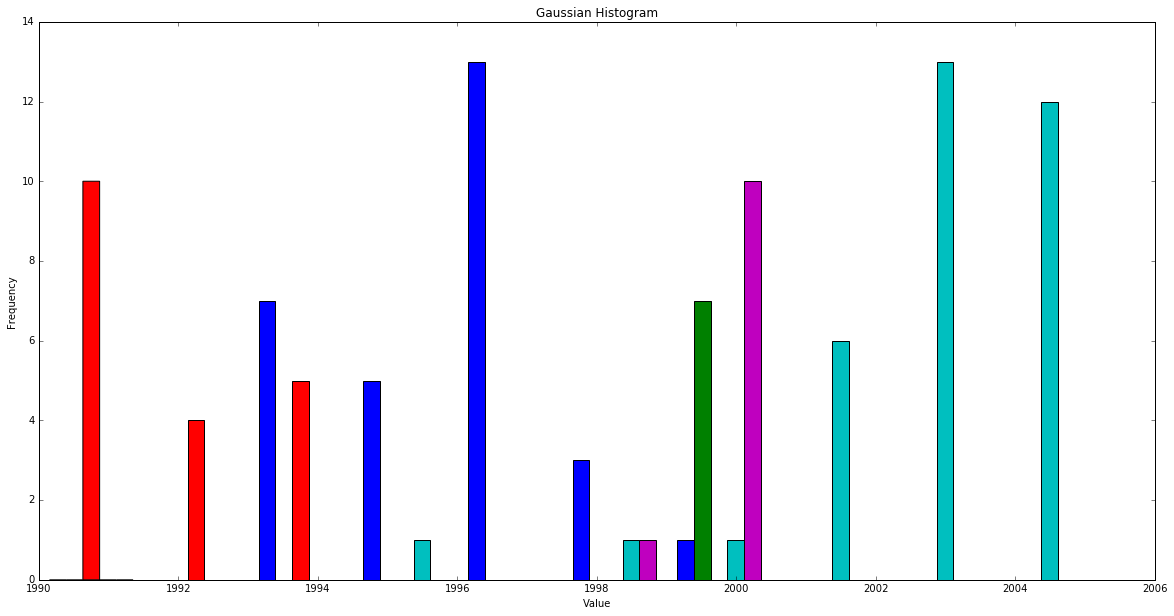

In [12]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20,10))
plt.hist(clusters_date_list)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


As you can see from the above hist, the green cluster and the purple cluster tend to center around 1999 and 2000. I believe they refer to the kosovo war and the elian gonzalez custody battle.

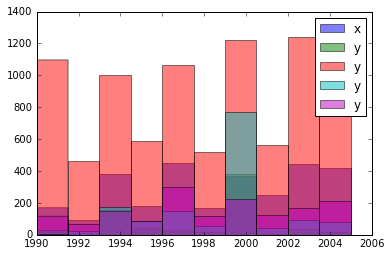

In [63]:
import numpy
from matplotlib import pyplot

x = clusters_date_list[0]
y = clusters_date_list[1]
z = clusters_date_list[2]
f = clusters_date_list[3]
g = clusters_date_list[4]



pyplot.hist(x, alpha=0.5, label='x')
pyplot.hist(y, alpha=0.5, label='y')
pyplot.hist(z, alpha=0.5, label='y')
pyplot.hist(f, alpha=0.5, label='y')
pyplot.hist(g, alpha=0.5, label='y')

pyplot.legend(loc='upper right')
pyplot.show()

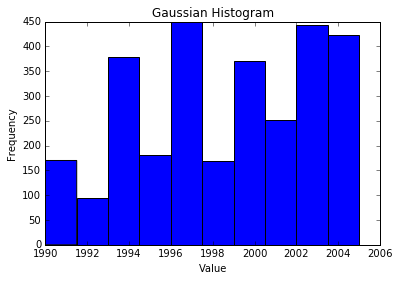

In [64]:
plt.hist(clusters_date_list[0])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

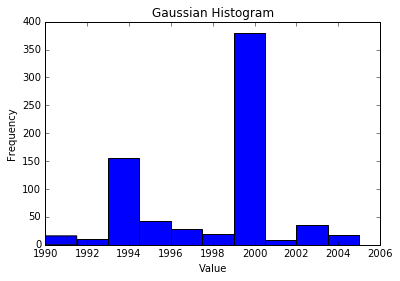

In [65]:
plt.hist(clusters_date_list[1])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

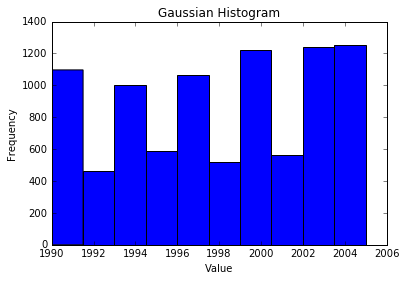

In [66]:
plt.hist(clusters_date_list[2])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

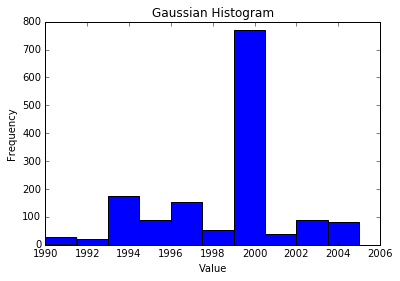

In [67]:
plt.hist(clusters_date_list[3])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

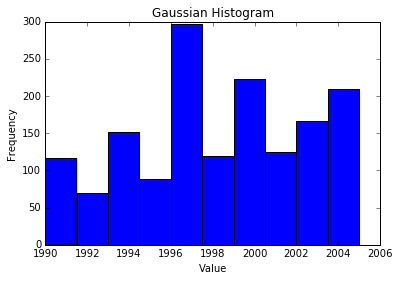

In [68]:
plt.hist(clusters_date_list[4])
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Multidimensional scaling

In [57]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [58]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [59]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: clusters_words[0], 
                 1: clusters_words[1], 
                 2: clusters_words[2], 
                 3: clusters_words[3], 
                 4: clusters_words[4]}

In [60]:
%matplotlib inline

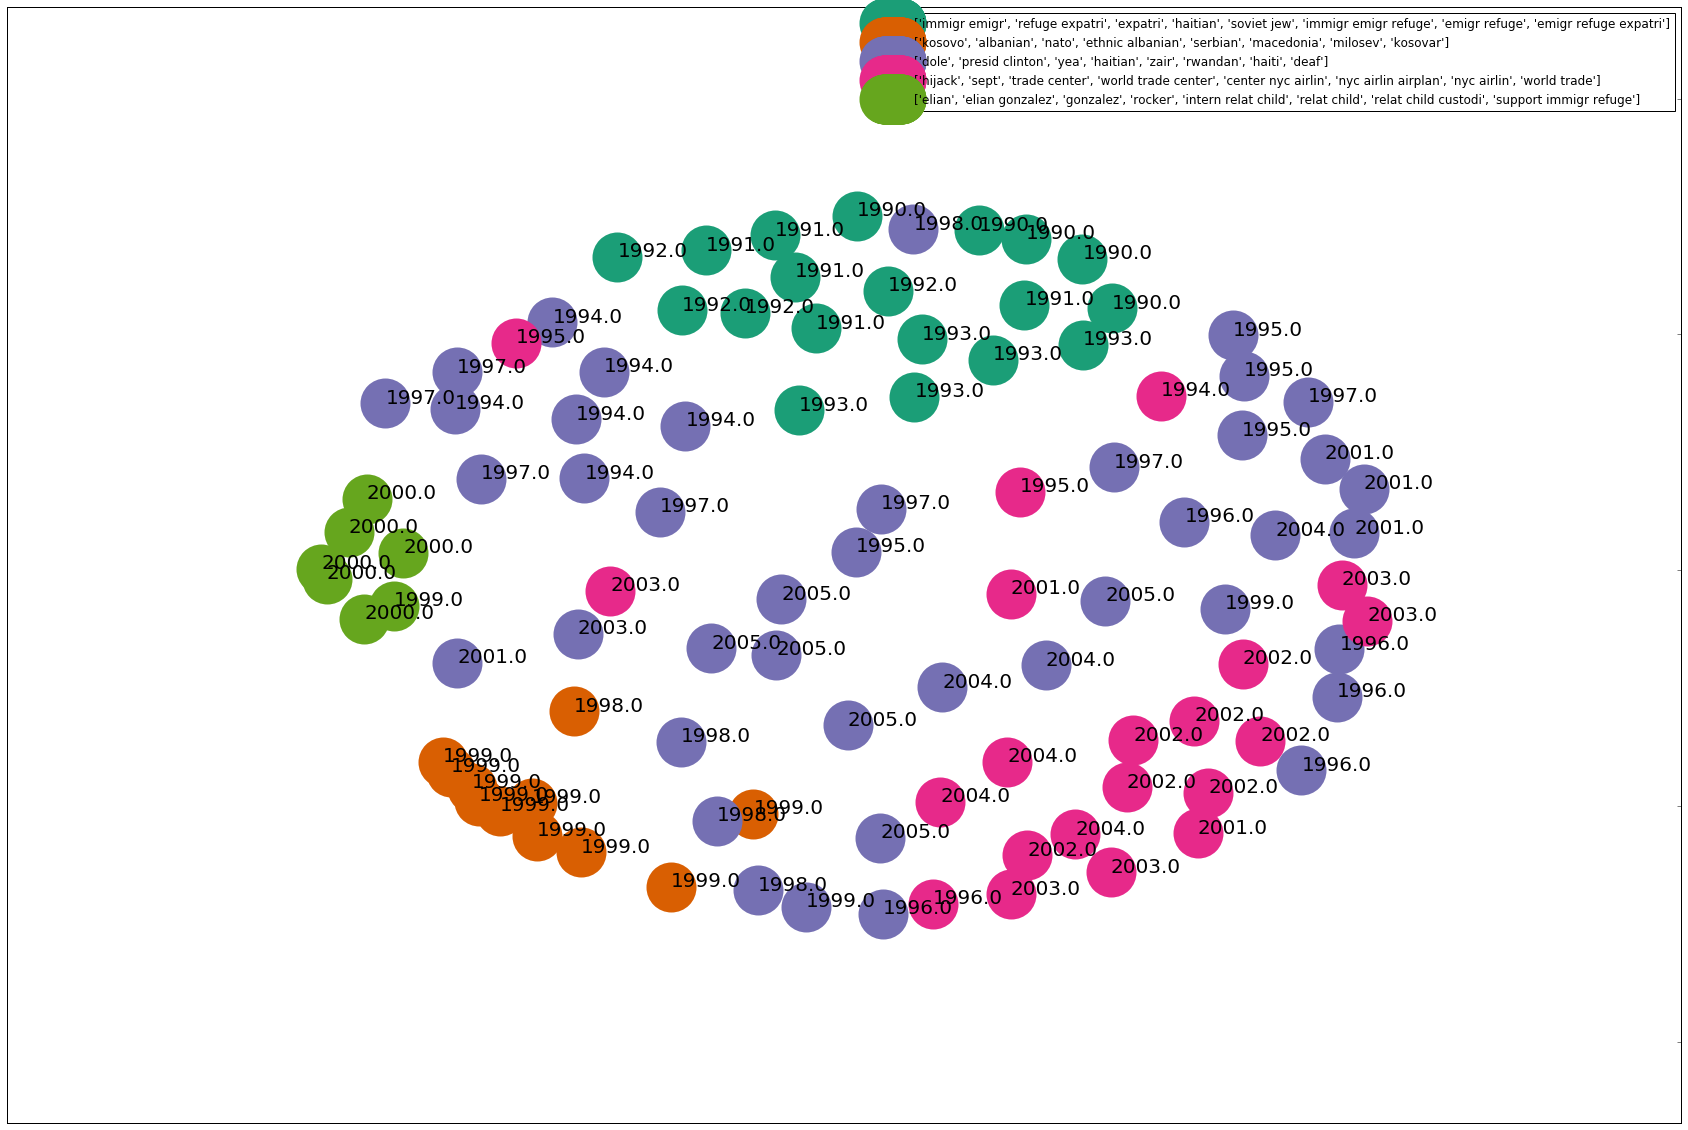

In [65]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=date)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(30, 20)) # set size
ax.margins(0.3) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=50, label=pair_list[name], linewidth=60.0, color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=50)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=20)  

    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

As you can see from above picture, the high dimentional bubbles are smashed into this 2 D plane. The spacial distance represents their closeness in meaning. And in one cluster, the bubbles tend to have close data tags, too.

In [46]:
plt.close()

In [55]:
import mpld3

In [56]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [57]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
titles = date

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=keywords)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

# svg.mpld3-figure {
# margin-left: -10px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(30, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=keywords);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=500) #save figure as ward_clusters

In [6]:

from IPython.display import Image
Image(filename='ward_clusters.png') 